In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import datetime
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import create_dataset, split_and_create_dataset, prepare_for_training
from utils import show_image, class_distribution
from utils import print_split_info, unpipe, tf_bincount, checkout_dataset
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')

conf = {
    # Dataset
    "data_dir": data_dir,
    "ds_info": 'hypkva',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0.7,
    "resample": False,
    "class_weight": True,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 2511,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model": 'EfficientNetB0',
    "weights": "imagenet",                   # which weights to initialize the model with
    "dropout": 0.2,
    "num_epochs": 4,
    "batch_size": 16,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.001,
    "optimizer": 'Adam',
    "final_activation": 'softmax',     # sigmoid for binary ds
    # Callbacks
    "tensorboard": False,
    "learning_schedule": False,
    "decay_rate": 0,                   # 128:0.25   64:1.0   32:4.0   16:16   8:64
    "checkpoint": False,
    "early_stopp": False,
    "early_stopp_patience": 7,
    # Misc
    "verbosity": 1,
    "keep_threshold": 0.0,
    "dir_name": "test",
    "log_dir": "./logs",
    "cache_dir": "./cache",
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
ds = create_dataset(conf)

Category                    : train | test  | val   | total | % of total 
------------------------------------------------------------------------
barretts-short-segment      :    37 |     8 |     8 |    53 |  0.50%
retroflex-stomach           :   534 |   115 |   115 |   764 |  7.17%
ulcerative-colitis-0-1      :    24 |     5 |     6 |    35 |  0.33%
ulcerative-colitis-grade-3  :    93 |    20 |    20 |   133 |  1.25%
esophagitis-b-d             :   182 |    39 |    39 |   260 |  2.44%
dyed-resection-margins      :   692 |   148 |   149 |   989 |  9.28%
hemorrhoids                 :     4 |     1 |     1 |     6 |  0.06%
normal-z-line               :   652 |   140 |   140 |   932 |  8.74%
esophagitis-a               :   282 |    60 |    61 |   403 |  3.78%
ulcerative-colitis-1-2      :     7 |     2 |     2 |    11 |  0.10%
barretts                    :    28 |     6 |     7 |    41 |  0.38%
bbps-2-3                    :   803 |   172 |   173 |  1148 | 10.77%
ileum                    

# Balancing the data

## Sample from dataset
Works alright, but reads the dataset num_classes times - so not very efficient

In [14]:
from utils import better_class_dist

initial_dist = better_class_dist(ds["clean_train"], conf["num_classes"])
target_dist = [1.0/conf["num_classes"]] * conf["num_classes"]

print (initial_dist)

[0.00496378 0.07163939 0.00321975 0.01247652 0.02441642 0.09283606
 0.00053662 0.08746981 0.03783204 0.00093909 0.00375637 0.10772739
 0.00080494 0.06063858 0.01220821 0.09471425 0.04158841 0.00254897
 0.09377515 0.03662463 0.01878186 0.09645828 0.09404347]


In [4]:
initial_dist, total_count = class_distribution(ds["clean_train"], conf["num_classes"])
target_dist = [1.0/conf["num_classes"]] * conf["num_classes"]

print (initial_dist)

[0.00496378 0.07163939 0.00321975 0.01247652 0.02441642 0.09283606
 0.00053662 0.08746982 0.03783204 0.00093909 0.00375637 0.10772739
 0.00080494 0.06063858 0.01220821 0.09471425 0.04158841 0.00254897
 0.09377515 0.03662463 0.01878186 0.09645828 0.09404346]


In [ ]:
datasets = []
for i in range(conf["num_classes"]):
    data = ds["clean_train"].filter(lambda image, label: label==i).repeat()
    datasets.append(data)

In [ ]:
balanced_ds = tf.data.experimental.sample_from_datasets(datasets, target_dist)

In [ ]:
new_count = tf_bincount(balanced_ds, conf["num_classes"])

In [ ]:
new_count

## Rejection resampling
Somehow seems to work-ish if all shuffling of data is disabled, but still gives weird results..

In [5]:
resample_ds = ds["clean_train"].apply(
        tf.data.experimental.rejection_resample(
            class_func=lambda image, label: label,
            target_dist=target_dist,
#             initial_dist=initial_dist,
            seed=21))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



extra_label: esophagitis-a
image and label: esophagitis-a


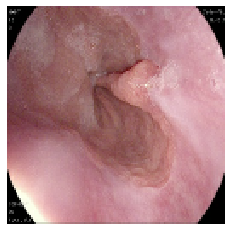

In [6]:
for extra_label, image_and_label in resample_ds.take(1):
    print ("extra_label:",conf["class_names"][extra_label.numpy()])
    print ("image and label:", conf["class_names"][image_and_label[1].numpy()])
    show_image(image_and_label[0])

In [7]:
# drop the extra labels (which should just be a copy)
balanced_ds = resample_ds.map(lambda extra_label, img_and_label: img_and_label)

retroflex-rectum
dyed-resection-margins


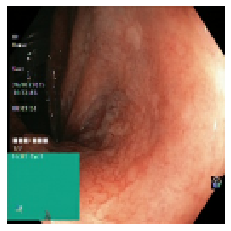

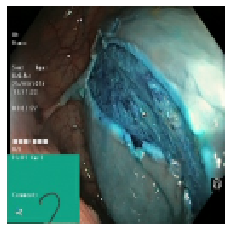

In [8]:
for image, label in balanced_ds.take(2):
    print (conf["class_names"][label.numpy()])
    show_image(image)

In [9]:
cnt = 0
for img, lab in balanced_ds:
    cnt += 1

print (cnt)

3475


In [10]:
final_count = tf_bincount(balanced_ds, 23)

In [11]:
final_count.sum()

3449.0

In [12]:
initial_dist

array([0.00496378, 0.07163939, 0.00321975, 0.01247652, 0.02441642,
       0.09283606, 0.00053662, 0.08746982, 0.03783204, 0.00093909,
       0.00375637, 0.10772739, 0.00080494, 0.06063858, 0.01220821,
       0.09471425, 0.04158841, 0.00254897, 0.09377515, 0.03662463,
       0.01878186, 0.09645828, 0.09404346], dtype=float32)

In [13]:
final_dist, total_count = class_distribution(balanced_ds, conf["num_classes"])

final_dist

array([0.00644783, 0.06594373, 0.00615475, 0.01758499, 0.02989449,
       0.08821806, 0.0017585 , 0.07913247, 0.04103165, 0.00293083,
       0.00674091, 0.09671747, 0.00263775, 0.06184056, 0.01787808,
       0.08792497, 0.04161782, 0.00674091, 0.09642439, 0.04249707,
       0.02227433, 0.09114888, 0.08645955], dtype=float32)